In [ ]:
import torch
import sys
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
from torchvision import datasets, transforms
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names
from PIL import Image
from tqdm import tqdm
import os
import numpy as np
from torchsummary import summary
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import HTML

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/DnnSecurity/Attack/BadNet')
from dataset_clean_cifar import MyDataset
from model import WideResNet

In [ ]:
# Prepare Env
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

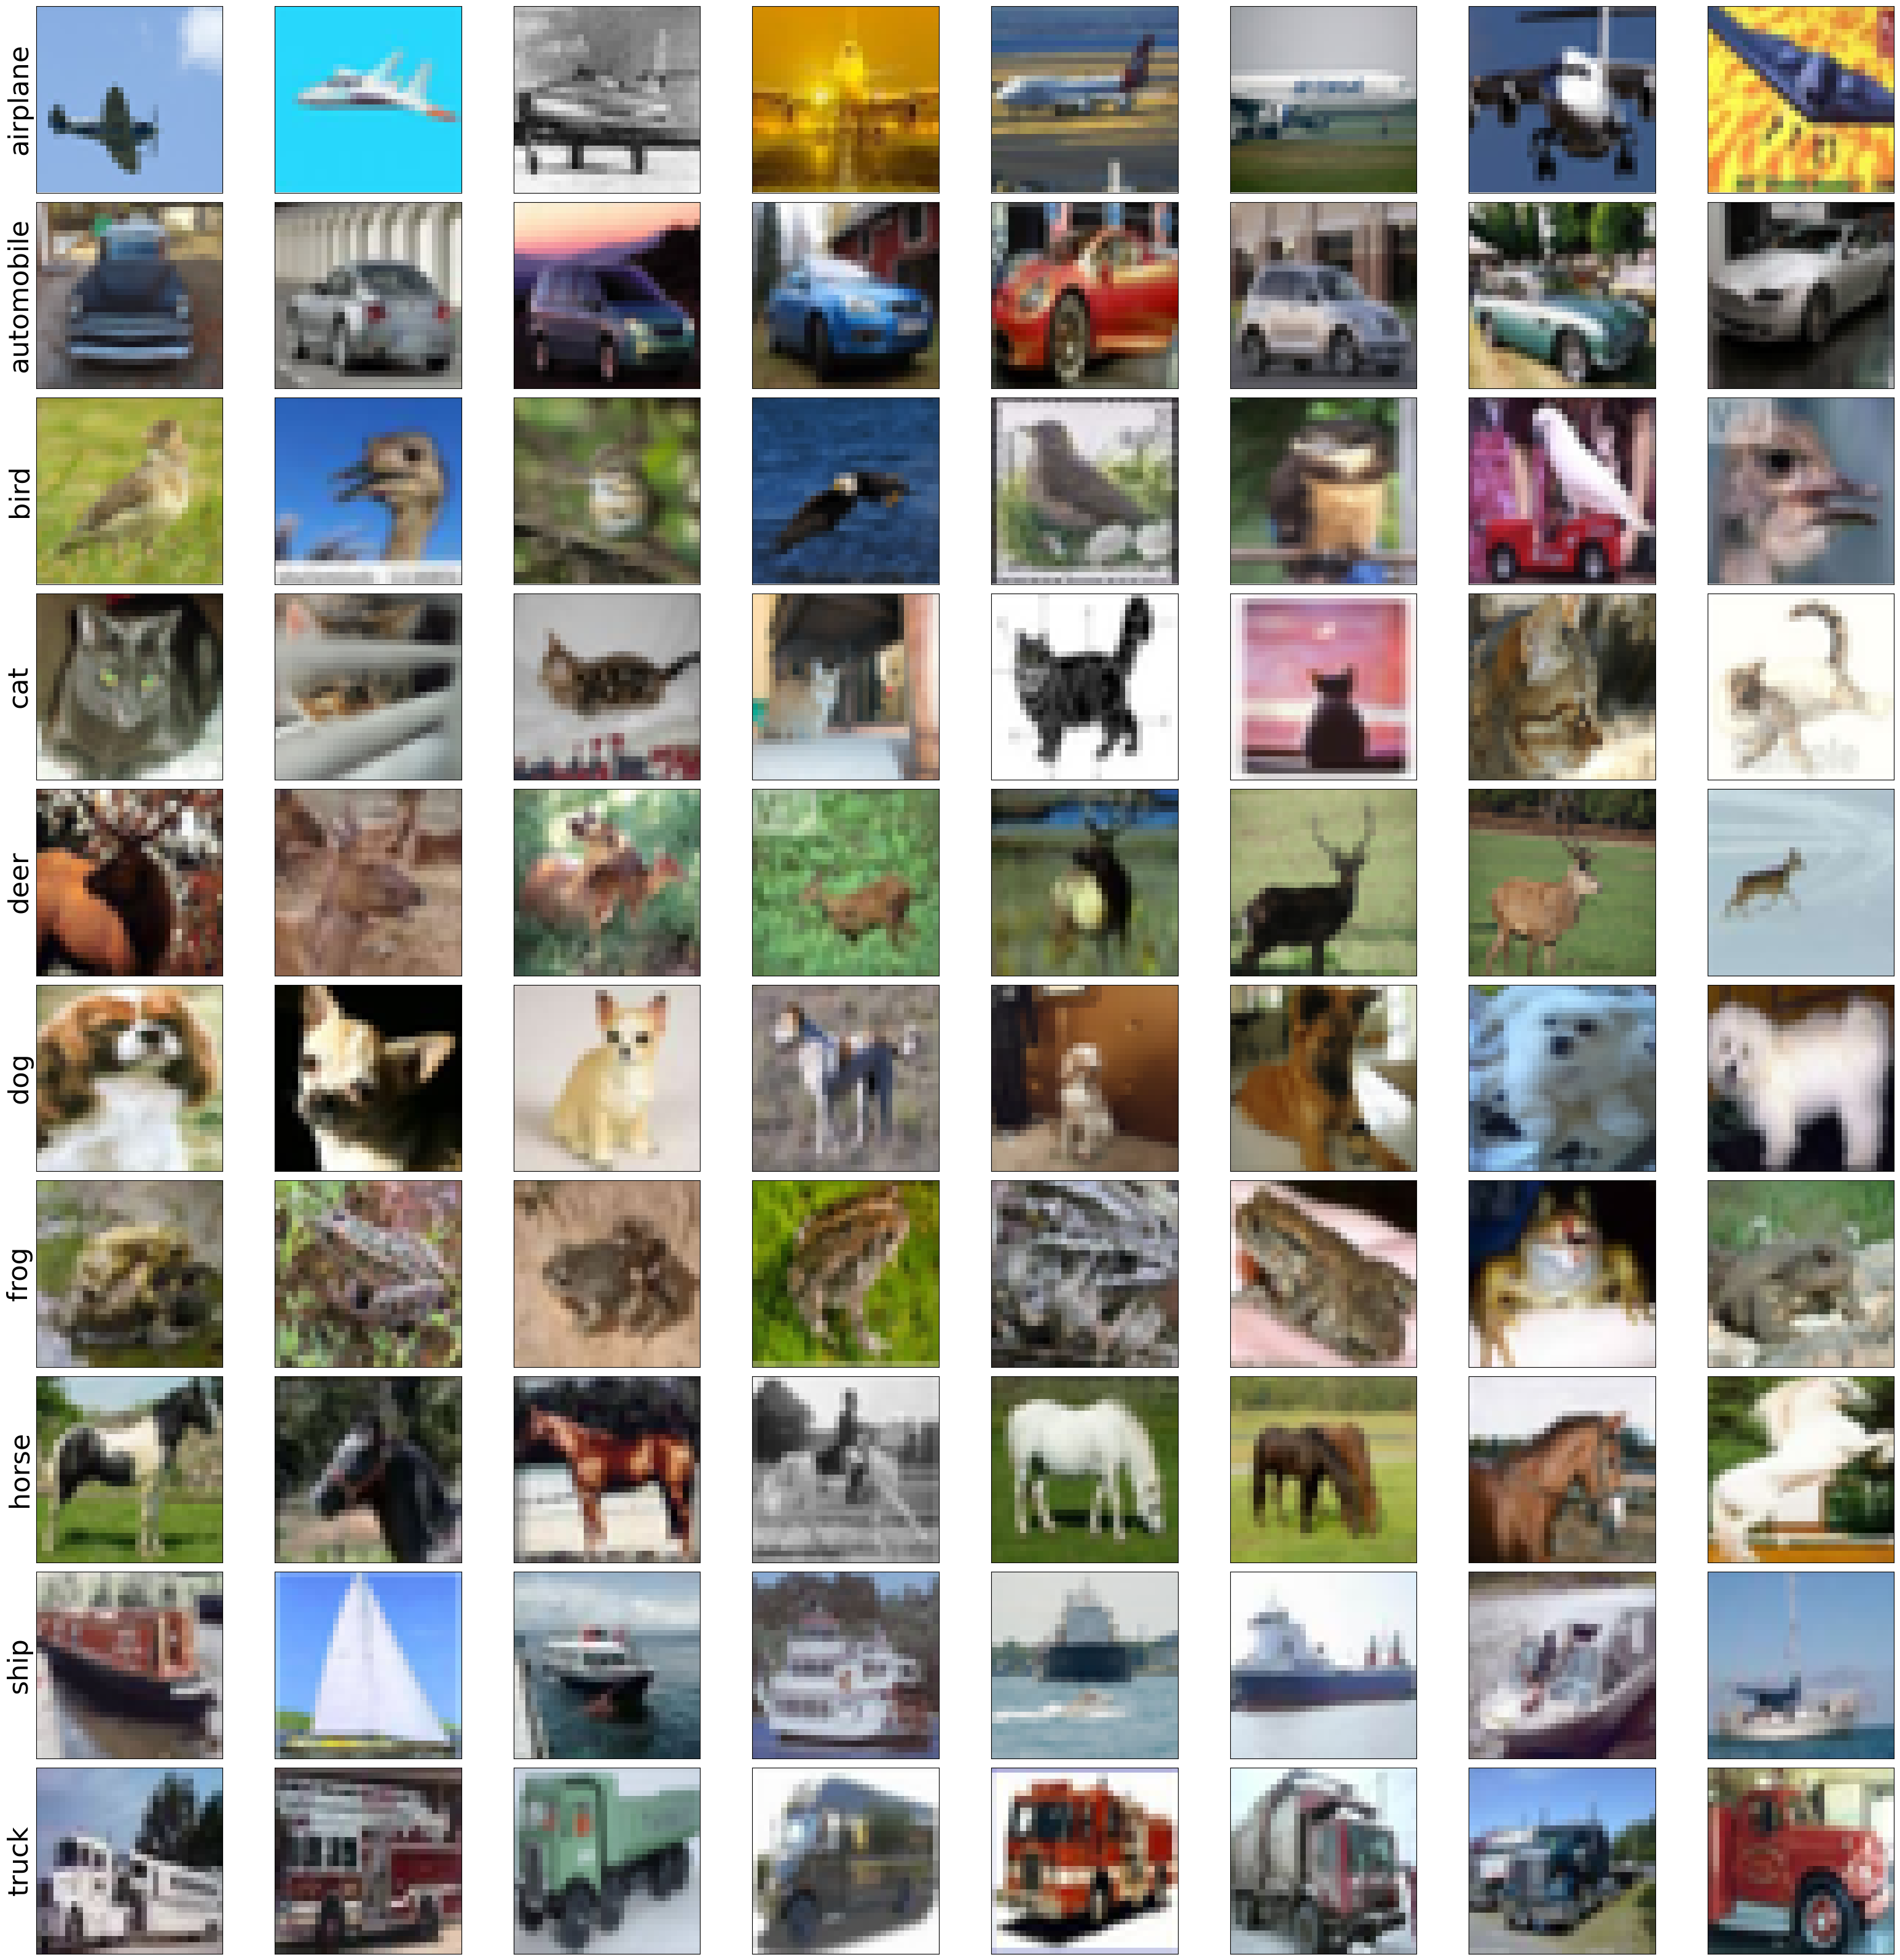

In [ ]:
train_folder = '/content/drive/MyDrive/cifar10/32_32/train'
transform = transforms.Compose([transforms.ToTensor()])
train_data_samples = datasets.ImageFolder(train_folder, transform=transform)

class_names = train_data_samples.classes
samples_per_class = 8

plt.figure(figsize=(32,32))

for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(train_folder, class_name)
    class_images = os.listdir(class_folder)
    chosen_samples = random.sample(class_images, samples_per_class)

    for i, img_name in enumerate(chosen_samples):
        img_path = os.path.join(class_folder, img_name)
        img = plt.imread(img_path)
        plt.subplot(len(class_names), samples_per_class, class_idx * samples_per_class + i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img)
        if i == 0:
            plt.ylabel(class_name, fontsize=32)

plt.tight_layout()
plt.show()

In [ ]:
test_data_folder = datasets.ImageFolder(root="/content/drive/MyDrive/cifar10/32_32/test/")
train_data_folder = datasets.ImageFolder(root="/content/drive/MyDrive/cifar10/32_32/train/")
train_data_folder = test_data_folder

portion = 1

print("Classes:")
for i in range(len(class_names)):
    print(str(i) + ":" + class_names[i])
print("Enter target class index from above classes i.e. 0:")
target = int(input())
print("Generate training data with poison")
print("----------------------------------")
train_data = MyDataset(train_data_folder, target, portion=portion, mode="train", device=device)
print("Generate testing data without backdoor trigger")
print("----------------------------------")
test_data_orig = MyDataset(test_data_folder, target, portion=0, mode="test", device=device)
print("Generate testing data with backdoor trigger")
print("----------------------------------")
test_data_trig = MyDataset(test_data_folder, target, portion=1, mode="test", device=device)

train_data_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_data_orig_loader = DataLoader(dataset=test_data_orig, batch_size=64, shuffle=True)
test_data_trig_loader = DataLoader(dataset=test_data_trig, batch_size=64, shuffle=True)

Classes:
0:airplane
1:automobile
2:bird
3:cat
4:deer
5:dog
6:frog
7:horse
8:ship
9:truck
Enter target class index from above classes i.e. 0:
Generate training data with poison
----------------------------------
Generating train Bad Imgs


 45%|████▍     | 4480/10000 [29:35<43:49,  2.10it/s]

In [ ]:
print("start training: ")
for i in range(epoch):
    loss_train = train(model, train_data_loader, criterion, sgd)
    acc_train = eval(model, train_data_loader)
    #print(f"epoch{i + 1}   loss: {loss_train:.5f}  training accuracy: {acc_train:.5f}  testing Orig accuracy: {acc_test_orig:.5f}  testing Trig accuracy: {acc_test_trig:.5f}")
    print(f"epoch{i + 1}   loss: {loss_train:.5f}  testing Trig accuracy: {acc_test_trig:.5f}")
    torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/DnnSecurity/Attack/BadNet/badnet_cifar.pth")
print("finish training")

In [ ]:
# Choose wanted image index
print("Image index:")
img_idx = int(input())

# List available layers in the model
train_nodes, eval_nodes = get_graph_node_names(model)
print("Available layers in the model:")
for node in eval_nodes:
    print(node)

# Input the wanted layer
print("Enter the target layer (copy from above list):")
target_layer = input()

# Validate the target layer
if target_layer not in eval_nodes:
    raise ValueError(f"Layer {target_layer} Invalid layer.")

# Get the image path from the dataset
img_path, _ = train_data_samples.imgs[img_idx]

# Load and preprocess the image
img = Image.open(img_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to the input size expected by the model
    transforms.ToTensor(),        # Convert image to tensor
])
image = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Define the layers to extract features
return_nodes = {
    target_layer: "target_layer_output"
}

# Create the feature extractor
model.eval()  # Set model to evaluation mode
model2 = create_feature_extractor(model, return_nodes=return_nodes)

# Get the intermediate outputs
with torch.no_grad():
    intermediate_outputs = model2(image)

# Access the output from the specified layer
target_layer_output = intermediate_outputs["target_layer_output"]
target_layer_output_np = target_layer_output.detach().cpu().numpy()

print(f"Output shape from {target_layer}: {target_layer_output_np.shape}")